## Load data

In [27]:
import pandas as pd
import string
from stop_words import get_stop_words

In [37]:
def cleanup_text(doc):
    text = doc.translate(str.maketrans('', '', string.punctuation))
    
    #strip additional characters:
    remove = ['”','“', '€','°','»','©']
    for char in remove:
        text = text.replace(char, '')
    
    text = text.lower()

    #stopwords
    stop_words = get_stop_words('spanish')
    tokens = text.split()
    text = [w for w in tokens if not w in stop_words]
    text = ' '.join(text)
    
    return text

def load_docs(path):
    """
    loads docs in csv format
    """
    df = pd.read_csv(path)
    df['numero_PL'] = df['numero_fecha_PL'].apply(lambda x: x.split('-')[0][-4:])   # keeps only the last 4 digits of the PL number
    df['texto'] = df['texto'].apply(lambda x: cleanup_text(x))
    # print(df.head(10))
    return df

In [38]:
docs = load_docs('../OCR/PL_sesion_12.2020.csv')
docs.head()

,numero_fecha_PL,texto,index,numero_PL
0,PL06839-20201219,congreso republica rolando campos villalobos c...,[0],6839
1,PL06849-20201221,flee ze ue of mec ano universalf ne municipali...,[0],6849
2,PL06799,ley modifica articulo 31 laley 30003 ley regul...,[0],6799
3,PL06796-20201214,proyecto leyn6 276 2020 cr sccesoccereoe 124 p...,[0],6796
4,PL06886-20201230,proyecto ley we sbe 2020 ce firmado digitalrne...,[0],6886


...

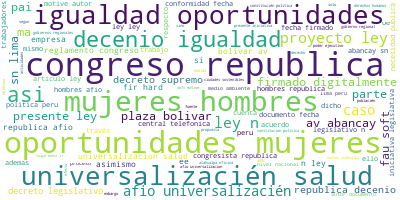

In [42]:
from wordcloud import WordCloud

long_string = ','.join(list(docs['texto'].values))
wordcloud = WordCloud(background_color="white", max_words=50000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

## Lemmatize

#### NOTE: Entity extraction would have to happen BEFORE lemmatization as it will mess with names

In [59]:
import spacy
from spacy_spanish_lemmatizer import SpacyCustomLemmatizer
# more info on rules based spanish lemmatizer at https://github.com/pablodms/spacy-spanish-lemmatizer

In [75]:
# !python3 -m spacy download es
# !pip3 install spacy_spanish_lemmatizer
# !python3 -m pip install --upgrade spacy_spanish_lemmatizer
# !python3 -m spacy_spanish_lemmatizer download wiki

In [91]:
def lematizar(text):
    nlp = spacy.load("es")
    lemmatizer = SpacyCustomLemmatizer()
    nlp.add_pipe(lemmatizer, name="lemmatizer", after="tagger")
    string = ''
    for token in nlp(text):
        string = string+' '+token.lemma_
    
    return string


In [92]:
docs['texto'] = docs['texto'].apply(lambda x: lematizar(x))

In [94]:
docs.head()

,numero_fecha_PL,texto,index,numero_PL
0,PL06839-20201219,congreso republica rolar campo villalobos con...,[0],6839
1,PL06849-20201221,flee ze ue of mec ano universalf ne municipal...,[0],6849
2,PL06799,ley modificar articular 31 laley 30003 ley re...,[0],6799
3,PL06796-20201214,proyectar leyn6 276 2020 cr sccesoccereoe 124...,[0],6796
4,PL06886-20201230,proyectar ley we sbe 2020 ce firmar digitalrn...,[0],6886


## Tf-idf vectoriztion

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [44]:
# countvectorizer = CountVectorizer(analyzer= 'word')
# count_wm = countvectorizer.fit_transform(docs['texto'])
# count_tokens = countvectorizer.get_feature_names()

In [96]:
tfidfvectorizer = TfidfVectorizer(analyzer='word')
tfidf_wm = tfidfvectorizer.fit_transform(docs['texto'])
tfidf_tokens = tfidfvectorizer.get_feature_names()

In [97]:
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)


In [98]:
print("\nTD-IDF Vectorizer\n")
print(df_tfidfvect)


TD-IDF Vectorizer

           00       000  0000  00000  000000  00000000  000016202020  \
0    0.000000  0.000000   0.0    0.0     0.0       0.0           0.0   
1    0.000000  0.000000   0.0    0.0     0.0       0.0           0.0   
2    0.000000  0.000000   0.0    0.0     0.0       0.0           0.0   
3    0.000000  0.000000   0.0    0.0     0.0       0.0           0.0   
4    0.000000  0.000000   0.0    0.0     0.0       0.0           0.0   
..        ...       ...   ...    ...     ...       ...           ...   
115  0.012799  0.000000   0.0    0.0     0.0       0.0           0.0   
116  0.000000  0.014882   0.0    0.0     0.0       0.0           0.0   
117  0.000000  0.000000   0.0    0.0     0.0       0.0           0.0   
118  0.000000  0.000000   0.0    0.0     0.0       0.0           0.0   
119  0.000000  0.000000   0.0    0.0     0.0       0.0           0.0   

     00002492020producedn  00003335  000062012ai  ...  ésccowccworoq  ésia  \
0                     0.0       0.0  

## LDA 

In [99]:
import gensim.corpora as corpora

In [113]:
# concat all text
all_words = docs['texto'].apply(lambda x: x.split())
print(all_words[0:10])

 congreso republica rolar campo villalobos congresista republica ley proteccion laboral trabajador a
0    [congreso, republica, rolar, campo, villalobos...
1    [flee, ze, ue, of, mec, ano, universalf, ne, m...
2    [ley, modificar, articular, 31, laley, 30003, ...
3    [proyectar, leyn6, 276, 2020, cr, sccesoccereo...
4    [proyectar, ley, we, sbe, 2020, ce, firmar, di...
5    [pmapects, ley, it, 64982020, fi, dry, peele, ...
6    [proyectar, ley, wgr1320, congreso, republica,...
7    [pye, rehnaa, dd, ongeso2, 182020, cr, resoluc...
8    [proyectar, ley, we, 6882, o2ocr, 44, dery, z,...
9    [firrado, digitalmente, combinar, salvatjerra,...
Name: texto, dtype: object


In [114]:
id2word = corpora.Dictionary(all_words)

In [115]:
texts = all_words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 4), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 6), (19, 1), (20, 7), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 3), (28, 1), (29, 1)]


In [117]:
import gensim
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.012*"ley" + 0.011*"salud" + 0.007*"nacional" + 0.007*"republica" + '
  '0.007*"articular" + 0.006*"congreso" + 0.006*"1" + 0.005*"derecho" + '
  '0.005*"—" + 0.004*"peru"'),
 (1,
  '0.011*"ley" + 0.008*"republica" + 0.006*"salud" + 0.005*"n" + '
  '0.005*"nacional" + 0.004*"articular" + 0.004*"publicar" + 0.004*"congreso" '
  '+ 0.004*"desarrollar" + 0.003*"servicio"'),
 (2,
  '0.010*"ley" + 0.009*"articular" + 0.006*"nacional" + 0.005*"congreso" + '
  '0.005*"republica" + 0.005*"—" + 0.004*"proyectar" + 0.004*"presentar" + '
  '0.004*"salud" + 0.004*"derecho"'),
 (3,
  '0.011*"ley" + 0.009*"salud" + 0.009*"n" + 0.008*"republica" + '
  '0.006*"nacional" + 0.005*"peru" + 0.005*"congreso" + 0.005*"presentar" + '
  '0.005*"servicio" + 0.005*"articular"'),
 (4,
  '0.010*"ley" + 0.007*"republica" + 0.007*"articular" + 0.005*"salud" + '
  '0.005*"presentar" + 0.005*"nacional" + 0.004*"congreso" + 0.004*"n" + '
  '0.004*"oportunidad" + 0.004*"—"'),
 (5,
  '0.007*"salud" + 0.007*"rep

In [127]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os

pyLDAvis.enable_notebook()
LDAvis_data_filepath = ('ldavis_prepared.pkl')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [129]:
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'lda.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.013459 -0.000724       1        1  22.478380
5      0.000262 -0.001348       2        1  14.641630
3      0.006424  0.003621       3        1  10.992122
6      0.000463  0.000834       4        1  10.357058
8     -0.000502  0.004344       5        1   9.830775
4      0.000139 -0.000643       6        1   8.364444
9     -0.002071 -0.012088       7        1   7.201515
2     -0.006309  0.003120       8        1   7.180217
1     -0.002907  0.001521       9        1   5.386844
7     -0.008958  0.001362      10        1   3.567018, topic_info=     Category         Freq       Term        Total  loglift  logprob
436   Default  3348.000000        ley  3348.000000  30.0000  30.0000
133   Default  2226.000000  articular  2226.000000  29.0000  29.0000
634   Default  2347.000000  republica  2347.000000  28.0000  28.0000
593   Default   968.000000  proyectar   968.000000  27.0000  27.0000
470   Default  1595.000000          n  1595.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
80    Topic10    27.013365       afio   890.223694  -0.1617  -6.0994
438   Topic10    27.245792      limar   915.832397  -0.1815  -6.0908
2237  Topic10    26.875633      mujer  1118.304199  -0.3949  -6.1045
2181  Topic10    25.694708     hombre   889.264160  -0.2107  -6.1494
5     Topic10    25.891846          1  1080.356934  -0.3977  -6.1418

[908 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
8995      1  0.234954       00120280
8995      2  0.234954       00120280
8995      3  0.234954       00120280
8995      8  0.234954       00120280
746       1  0.280950  0132020mpaasa
...     ...       ...            ...
741       6  0.110642              ‘
741       7  0.069546              ‘
741       8  0.063224              ‘
741       9  0.044257              ‘
741      10  0.031612              ‘

[3880 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 4, 7, 9, 5, 10, 3, 2, 8])